In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from lux.lux import LUX
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset creation
We create here a very wellknown problem of a XOR problem that demonstrates limitations of the decision-tree-based algorithms that many explainers are based on (LORE, EXPLAN).
This code generates a synthetic dataset for a XOR classification problem with added noise, specifically in the third dimension of the data. XOR problems are commonly used to test the learning ability of machine learning models because the decision boundary is nonlinear and cannot be separated linearly. Here’s a detailed breakdown:

### Data Generation for XOR Problem
The XOR problem consists of four distinct groups of data points (clusters) in a 2D space:
```
a and b represent clusters labeled as 0.
c and d represent clusters labeled as 1.
```
Each group of 100 data points is generated using a multivariate normal distribution, meaning that each cluster has a specified mean and covariance, resulting in circularly distributed points around the mean.

Clusters labeled 0:

```python 
a = np.random.multivariate_normal(mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=100)  # Cluster centered at (0, 0)
al = np.zeros(100)  # Label for `a`
b = np.random.multivariate_normal(mean=[1, 1], cov=[[0.05, 0], [0, 0.05]], size=100)  # Cluster centered at (1, 1)
bl = np.zeros(100)  # Label for `b`
```

Points around (0, 0) and (1, 1) are labeled as 0.


Clusters labeled 1:

```python
c = np.random.multivariate_normal(mean=[0, 1], cov=[[0.05, 0], [0, 0.05]], size=100)  # Cluster centered at (0, 1)
cl = np.ones(100)  # Label for `c`
d = np.random.multivariate_normal(mean=[1, 0], cov=[[0.05, 0], [0, 0.05]], size=100)  # Cluster centered at (1, 0)
dl = np.ones(100)  # Label for `d`
```

Points around (0, 1) and (1, 0) are labeled as 1.

### Adding Noise in the Third Dimension
The noise array introduces randomness (with some bias) as an additional dimension:

```python
noise = np.array([np.random.choice(np.arange(0, 2), p=[0.7, 0.3]) for i in range(0, 400)])
```
A value of 0 is chosen 70% of the time and 1 is chosen 30% of the time.
This represents noisy data that is irrelevant to the XOR decision boundary but may confuse greedy algorithms like decision trees.

### Concatenating Data and Labels
Finally, all clusters are combined to form the complete dataset:

```python
labels = np.concatenate((al, bl, cl, dl))  # Combine labels from all clusters
xor = np.concatenate((a, b, c, d))         # Combine data points from all clusters
```

labels: A vector of binary labels (0 or 1).
xor: A matrix of 2D points representing the data.

In [54]:
a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #0
al = np.zeros(100)
b = np.random.multivariate_normal( mean=[1, 1], cov=[[0.05, 0], [0, 0.05]], size=100) #0
bl = np.zeros(100)
c = np.random.multivariate_normal( mean=[0, 1], cov=[[0.05, 0], [0, 0.05]], size=100) #1
cl = np.ones(100)
d = np.random.multivariate_normal( mean=[1, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #1
dl = np.ones(100)
noise = np.array([np.random.choice(np.arange(0, 2), p=[0.7,0.3]) for i in range(0,400)])
labels = np.concatenate((al,bl,cl,dl))
xor = np.concatenate((a,b,c,d))


In [55]:
noise_labels = np.abs(labels-noise)
xornoise = np.concatenate((xor, noise_labels.reshape(-1,1)), axis=1)
dataset = np.concatenate((xornoise, labels.reshape(-1,1)),axis=1)

d2 = False
if d2:
    dataset = np.concatenate((xor, labels.reshape(-1,1)),axis=1)



In [56]:
if d2:
    xords = pd.DataFrame(dataset, columns=['x1','x2','class'])
    features = ['x1','x2']
    target='class'
else:
    xords = pd.DataFrame(dataset, columns=['x1','x2','x3','class'])
    features = ['x1','x2','x3']
    target='class'

In [57]:
xords[target] = xords[target].astype(int)

In [58]:

train, test = train_test_split(xords, random_state=42)
clf = RandomForestClassifier(random_state=42)# svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

0.98

Text(0.5, 1.0, 'Projection of a dataset to 2D. Third dimension contain noise.')

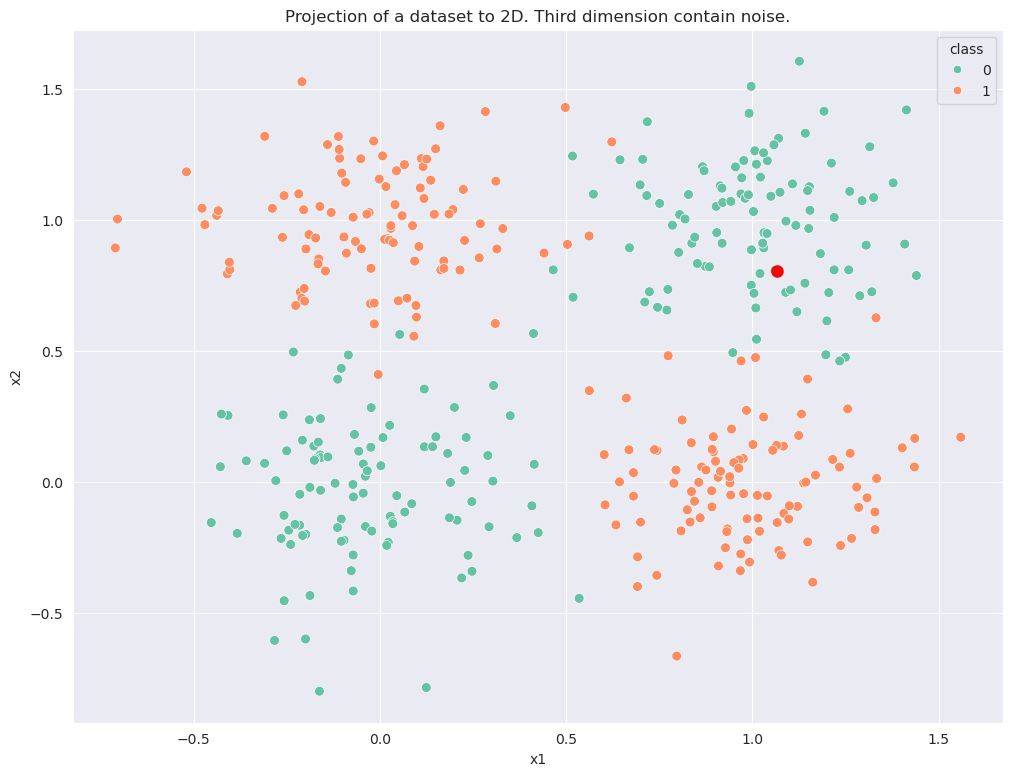

In [59]:
i2e = train.iloc[len(train)-1][features].values.reshape(1,-1)
plt.figure(figsize=(12,9))
graph=sns.scatterplot(data=xords,x='x1',y='x2',hue='class',palette='Set2')
graph.collections[0].set_sizes([50])      
features = [f for f in xords.columns if f not in ['class']]
target = 'class'
graph.axes.plot(i2e[0][0], i2e[0][1], 'or', markersize=8)
plt.title('Projection of a dataset to 2D. Third dimension contain noise.')
#plt.savefig('./pix/F1_scatterplot.pdf', format='pdf',bbox_inches='tight')

## Balckbox model fearture usage
We can see that the blackbox model correctly used x1 and x2 variable as most informative, while x3 that contains noise is left as almost unused

In [64]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(clf, train[features])
shap_values = explainer.shap_values(train[features],check_additivity=False)

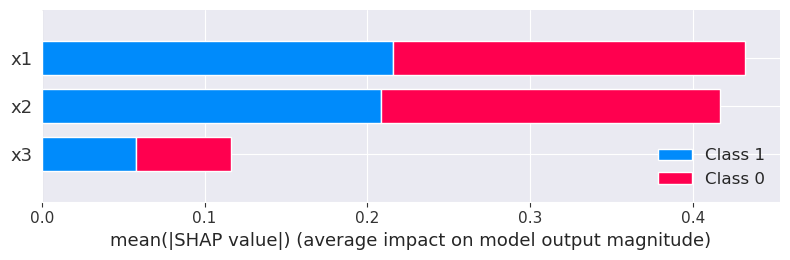

In [65]:
plt.figure()
shap.summary_plot(shap_values, features=None, feature_names=features, max_display=None, show=False)
plt.savefig('shap-wine.png', format='png',bbox_inches='tight')
plt.show()

## Greedy approach
It is more likely to use x3 variable which is noise variable only because it limits the entropy better.

In [60]:
lux = LUX(predict_proba = clf.predict_proba, 
          #classifier=clf, 
          neighborhood_size=int(len(train)*0.4),max_depth=2,  node_size_limit = 10, grow_confidence_threshold = 0)
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1],n_jobs=1,inverse_sampling=True, density_sampling=False, use_parity=True, oversampling=True,oblique=False)
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


['IF x3 <0.5 THEN class = 0 # 0.644927536231884\n']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

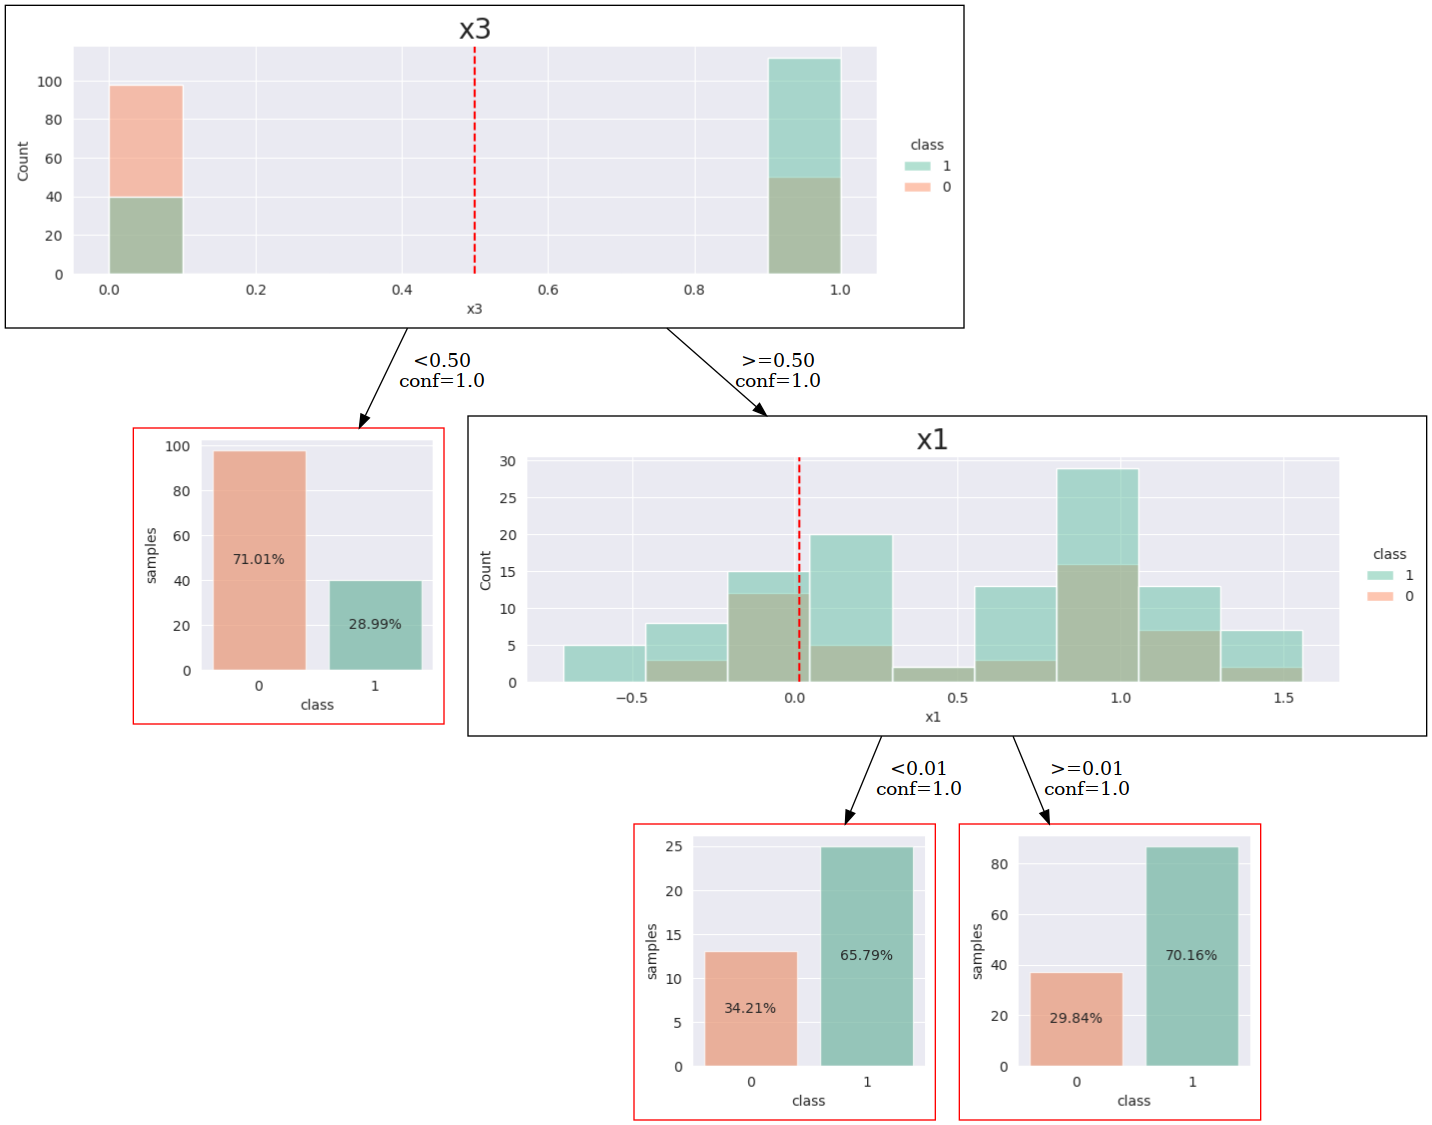

In [61]:
from IPython.display import Image
import graphviz
lux.uid3.tree.save_dot('./greedy.dot',fmt='.2f',visual=True, background_data=train)
gvz=graphviz.Source.from_file('./greedy.dot')
!dot -Tpng greedy.dot > greedy.png
Image('greedy.png')

# SHAP-guided
SHAP guided approach takes the features which were truely used by the balckbox model

In [62]:
lux = LUX(predict_proba = clf.predict_proba, 
          classifier=clf, 
          neighborhood_size=int(len(train)*0.3),max_depth=2,  node_size_limit = 10, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1],n_jobs=1,inverse_sampling=True, density_sampling=True, use_parity=True, oversampling=True)
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier wa

['IF x2 >=0.36605240404605865 AND x1 >=0.6462397575378418 THEN class = 0 # 0.9805825242718447\n']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

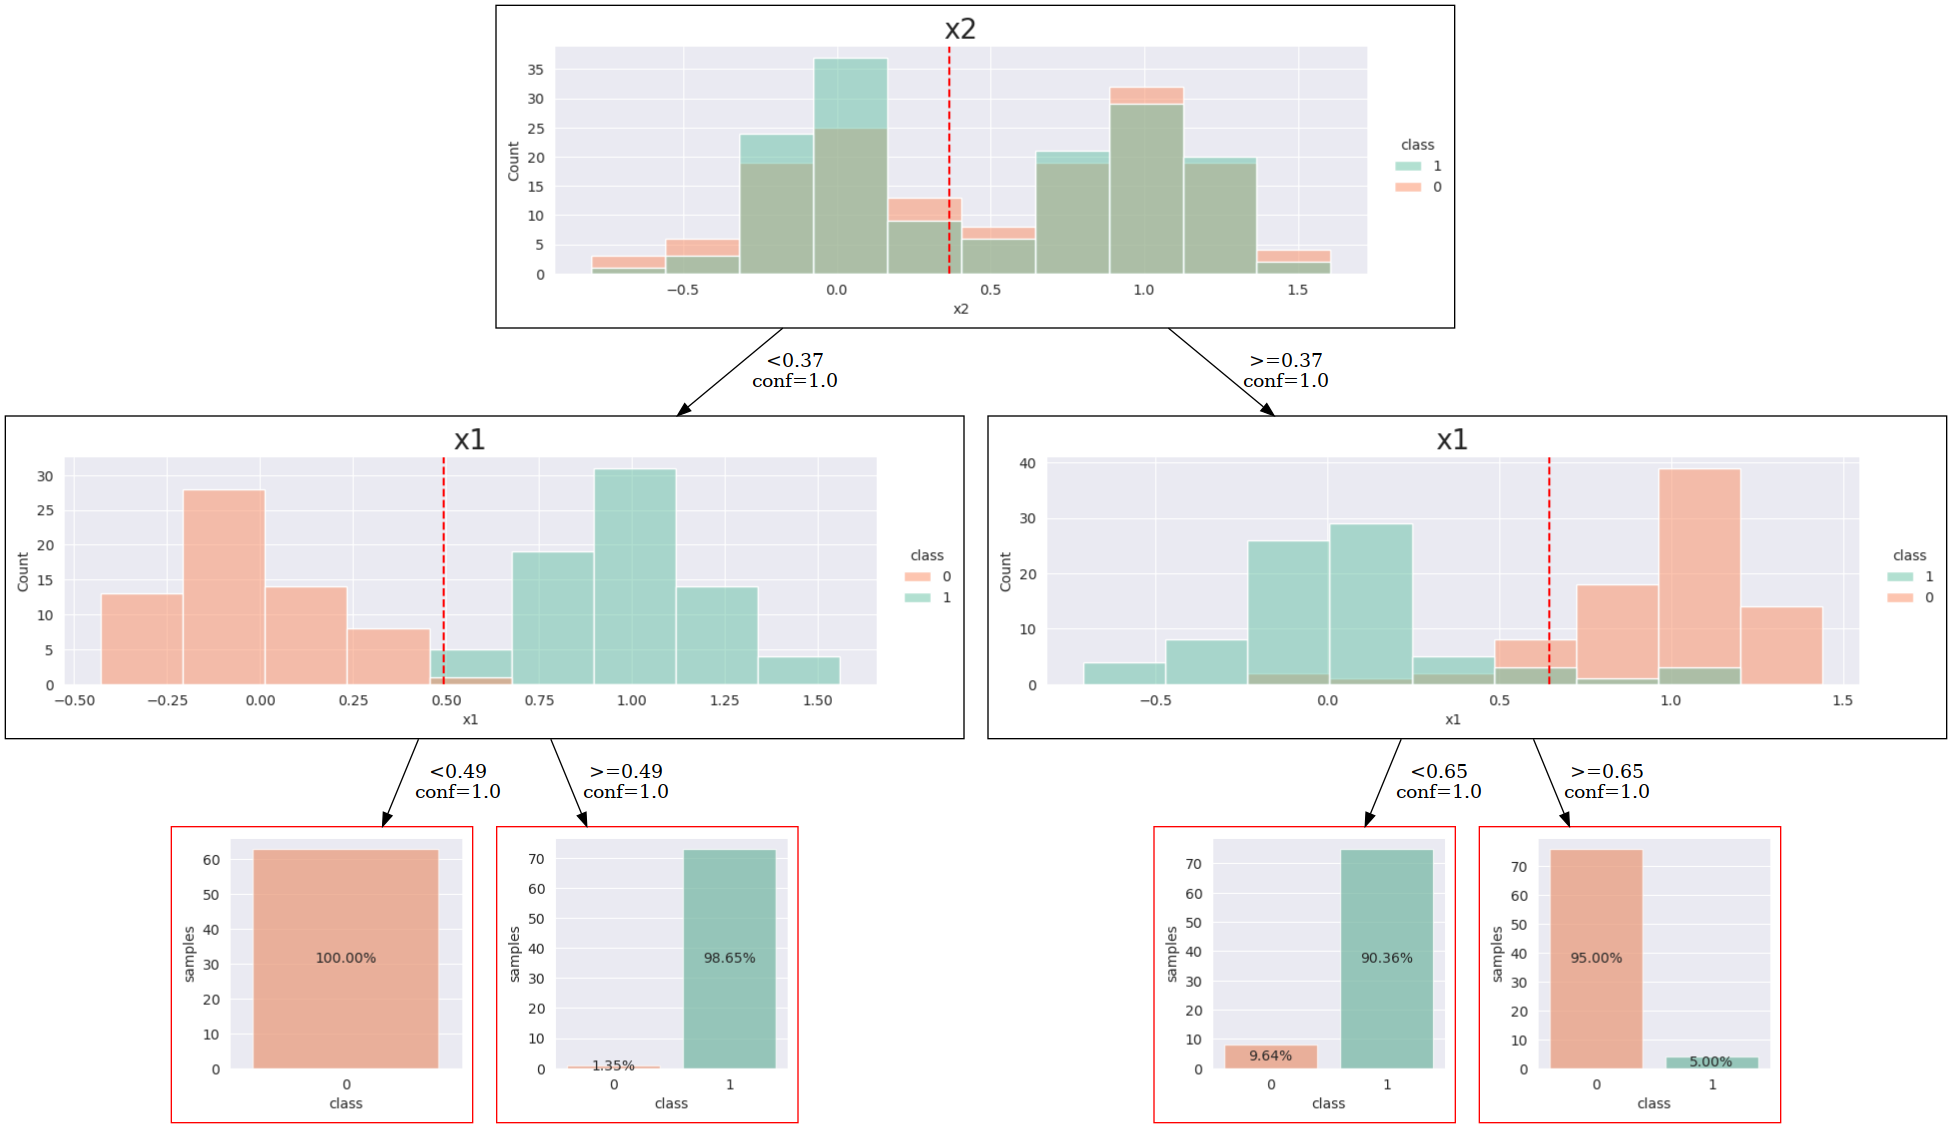

In [63]:
from IPython.display import Image
import graphviz
lux.uid3.tree.save_dot('./shap.dot',fmt='.2f',visual=True, background_data=train)
gvz=graphviz.Source.from_file('./shap.dot')
!dot -Tpng shap.dot > shap.png
Image('shap.png')